# Actividad 1: Multiplicación de matrices y paralelización

En esta actividad se va a realizar la implementación, descomposición y test de algoritmos de multiplicación de matrices

## Requisitos de la actividad

### Algoritmo de multiplicación simple
- Programar un algoritmo de multiplicación de matrices **cuadradas de igual tamaño**
- Las matrices se generarán de forma aleatoria mediante `numpy.random.rand`
- La multiplicación debe realizarse en **Python puro**, sin utilizar las funciones de NumPy (como `np.dot`)

### Algoritmo por bloques
- Realizar una versión **por bloques** del algoritmo anterior
- Parámetros configurables:
  - **N** = cantidad de bloques (NxN bloques en total)
  - **M** = medida de los bloques (MxM unidades cada bloque)
- Cada matriz estará compuesta por **NxN bloques de MxM unidades**
- Cada operación a ejecutar en paralelo debe estar en una **función independiente**

### Test de validación
- Realizar un test para verificar que los resultados de los algoritmos 1 y 2 son **iguales**
- Para unir una matriz en bloques se puede usar `numpy.block`
- Se puede usar el código del punto 1 en el punto 3
- En el test se puede usar `np.dot` **solo para validación**



In [1]:
import numpy as np
import time

def multiplicacion_simple(A, B):
    N = len(A)
    resultado = [[0.0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            suma_total = 0
            for k in range(N):
                suma_total += A[i][k] * B[k][j]
            resultado[i][j] = suma_total
    return resultado

N = 50
print(f"Generando matrices de {N}x{N}...")

np.random.seed(42)
matriz_A = np.random.rand(N, N)
matriz_B = np.random.rand(N, N)

inicio = time.time()
resultado_manual = multiplicacion_simple(matriz_A, matriz_B)
fin = time.time()
tiempo_secuencial = fin - inicio

print(f"Tiempo tardado: {tiempo_secuencial:.4f} segundos")

resultado_correcto = np.dot(matriz_A, matriz_B)
es_correcto = np.allclose(resultado_manual, resultado_correcto)

if es_correcto:
    print("El cálculo es perfecto.")
else:
    print("Algo ha salido mal.")

Generando matrices de 50x50...
Tiempo tardado: 1.7648 segundos
El cálculo es perfecto.


## 2. Algoritmo por bloques (versión paralela)

### Descripción
Esta celda implementa la version por bloques paralela del algoritmo de multiplicación de matrices

### Parámetros configurables
- N = 3: cantidad de bloques (matriz de 3x3 bloques)
- M = 50: tamaño de cada bloque (50x50 elementos)
- Matriz total: 150x150 elementos (3×50 = 150)

### Arquitectura del código
1. `multiply_manual(A, B)`: multiplica dos matrices en Python puro
2. `sumar_manual(A, B)`: suma dos matrices en Python puro
3. `calcular_un_bloque(datos)`: función que calcula UN bloque C[i][j] del resultado
   - Recibe: índices (i, j), fila de bloques de A, columna de bloques de B
   - Devuelve: tupla (i, j, bloque_resultante)

### Paralelización
- Usa `multiprocessing.Pool` para distribuir el trabajo
- Cada bloque se calcula en un proceso independiente
- Utiliza todos los núcleos disponibles (`cpu_count()`)

### Validación
- Usa `np.block` para reconstruir la matriz completa
- Compara con `np.dot` para verificar exactitud
- Muestra tiempo de ejecución parlaela

In [2]:
import numpy as np
import time
from multiprocessing import Pool, cpu_count

def multiply_manual(A, B):
    n = len(A)
    C = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            valor = 0
            for k in range(n):
                valor += A[i][k] * B[k][j]
            C[i][j] = valor
    return np.array(C)

def sumar_manual(A, B):
    n = len(A)
    C = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            C[i][j] = A[i][j] + B[i][j]
    return np.array(C)

def calcular_un_bloque(datos):
    i, j, fila_bloques_A, col_bloques_B = datos
    M = len(fila_bloques_A[0])
    N = len(fila_bloques_A)
    resultado_bloque = np.zeros((M, M))
    for k in range(N):
        producto = multiply_manual(fila_bloques_A[k], col_bloques_B[k])
        resultado_bloque = sumar_manual(resultado_bloque, producto)
    return (i, j, resultado_bloque)

if __name__ == '__main__':
    N = 3
    M = 50

    print(f"Matrices por bloques (N={N}, M={M})...")

    np.random.seed(42)
    A_bloques = [[np.random.rand(M, M) for _ in range(N)] for _ in range(N)]
    B_bloques = [[np.random.rand(M, M) for _ in range(N)] for _ in range(N)]

    lista_tareas = []
    for i in range(N):
        for j in range(N):
            fila_A = A_bloques[i]
            col_B  = [B_bloques[k][j] for k in range(N)]
            lista_tareas.append((i, j, fila_A, col_B))

    print(f"Lanzando {len(lista_tareas)} tareas al Pool de procesos...")

    start = time.time()

    with Pool(processes=cpu_count()) as pool:
        resultados = pool.map(calcular_un_bloque, lista_tareas)

    end = time.time()
    print(f"Tiempo Paralelo: {end - start:.4f} s")

    C_bloques_final = [[None]*N for _ in range(N)]
    for i, j, bloque in resultados:
        C_bloques_final[i][j] = bloque

    A_full = np.block(A_bloques)
    B_full = np.block(B_bloques)
    C_full = np.block(C_bloques_final)

    C_referencia = np.dot(A_full, B_full)

    if np.allclose(C_full, C_referencia):
        print("El cálculo paralelo es correcto.")
    else:
        print("El resultado no coincide.")

Matrices por bloques (N=3, M=50)...
Lanzando 9 tareas al Pool de procesos...


Tiempo Paralelo: 10.0873 s
El cálculo paralelo es correcto.


## 3. Test completo de validación y comparación

### Objetivo
Verificar que TODOS los algoritmos (Simple, Bloques Secuencial, Bloques Paralelo) producen resultados idénticos

### Lo que hace este test

1. Ejecuta los 3 algoritmos con las mismas matrices de entrada:
   - Algoritmo 1: Multiplicación Simple (Python puro)
   - Algoritmo 2: Por Bloques (Secuencial)
   - Algoritmo 3: Por Bloques (Paralelo con multiprocessing)

2. Validación cruzada:
   - Compara cada algoritmo contra `np.dot` (referencia)
   - Compara cada algoritmo entre sí
   - Usa `np.allclose` para comparación con tolerancia numérica

3. Análisis de rendimiento:
   - Mide tiempo de ejecución de cada algoritmo
   - Calcula Speedup: ganancia de velocidad con paralelización
   - Calcula Eficiencia: porcentaje de uso de los cores

### Funciones clave
- `algoritmo_simple()`: implementación clásica O(n³)
- `algoritmo_bloques_secuencial()`: versión por bloques sin paralelismo
- `algoritmo_bloques_paralelo()`: versión por bloques con multiprocessing

### Resultado esperado
Todos los tests deben mostrar `True`, indicando que:
- Los 3 algoritmos producen resultados idénticos
- Solo difieren en tiempo de ejecución (no en exactitud)

In [3]:
import numpy as np
import time
from multiprocessing import Pool, cpu_count


# ============================================================
# FUNCIONES AUXILIARES (Python puro - sin numpy.dot)
# ============================================================

def multiply(A, B):
    """Multiplicación de matrices (filas x columnas) en Python puro"""
    n = len(A)
    C = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            val = 0
            for k in range(n):
                val += A[i][k] * B[k][j]
            C[i][j] = val
    return np.array(C)

def sumar(A, B):
    """Suma simple de dos matrices en Python puro"""
    n = len(A)
    C = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            C[i][j] = A[i][j] + B[i][j]
    return np.array(C)

# ============================================================
# ALGORITMO 1: Multiplicación Simple (Python Puro)
# ============================================================

def algoritmo_simple(A, B):
    """Algoritmo 1: Multiplicación clásica de matrices"""
    N = len(A)
    resultado = [[0.0] * N for _ in range(N)]

    for i in range(N):
        for j in range(N):
            suma_total = 0
            for k in range(N):
                suma_total += A[i][k] * B[k][j]
            resultado[i][j] = suma_total

    return np.array(resultado)

# ============================================================
# ALGORITMO 2: Multiplicación por Bloques (Secuencial)
# ============================================================

def algoritmo_bloques_secuencial(A_bloques, B_bloques):
    """Algoritmo 2a: Versión por bloques SECUENCIAL"""
    N = len(A_bloques)
    M = len(A_bloques[0][0])

    C_bloques = [[np.zeros((M, M)) for _ in range(N)] for _ in range(N)]

    for i in range(N):
        for j in range(N):
            for k in range(N):
                prod = multiply(A_bloques[i][k], B_bloques[k][j])
                C_bloques[i][j] = sumar(C_bloques[i][j], prod)
    return C_bloques

# ============================================================
# ALGORITMO 3: Multiplicación por Bloques (Paralelo)
# ============================================================

def tarea_bloque(datos):
    """Función para calcular UN bloque C[i][j] en paralelo"""
    i, j, fila_A, col_B = datos
    N = len(fila_A)
    M = len(fila_A[0])

    bloque_res = np.zeros((M, M))
    for k in range(N):
        prod = multiply(fila_A[k], col_B[k])
        bloque_res = sumar(bloque_res, prod)

    return (i, j, bloque_res)

def algoritmo_bloques_paralelo(A_bloques, B_bloques):
    """Algoritmo 2b: Versión por bloques PARALELA"""
    N = len(A_bloques)
    lista_tareas = []

    for i in range(N):
        for j in range(N):
            fila_A = A_bloques[i]
            col_B = [B_bloques[k][j] for k in range(N)]
            lista_tareas.append((i, j, fila_A, col_B))

    with Pool(processes=cpu_count()) as pool:
        resultados = pool.map(tarea_bloque, lista_tareas)

    C_bloques = [[None]*N for _ in range(N)]
    for i, j, blq in resultados:
        C_bloques[i][j] = blq

    return C_bloques

# ============================================================
# TEST COMPLETO INTEGRAL
# ============================================================

if __name__ == '__main__':
    # Configuración: N bloques de tamaño M
    N = 3  # Cantidad de bloques (3x3)
    M = 40  # Tamaño de cada bloque (matriz total: 120x120)

    print("="*70)
    print(f"TEST COMPLETO DE LOS 3 ALGORITMOS")
    print(f"Configuración: {N}x{N} bloques de {M}x{M} (Total: {N*M}x{N*M})")
    print("="*70)
    print()

    # Generación de datos aleatorios
    np.random.seed(42)
    print("Generando matrices aleatorias...")
    A_bloques = [[np.random.rand(M, M) for _ in range(N)] for _ in range(N)]
    B_bloques = [[np.random.rand(M, M) for _ in range(N)] for _ in range(N)]

    # Unir bloques para tener matrices completas
    A_full = np.block(A_bloques)
    B_full = np.block(B_bloques)
    print(f"✓ Matrices generadas: {A_full.shape[0]}x{A_full.shape[1]}")
    print()

    # ========================================================
    # EJECUTAR ALGORITMO 1: Simple
    # ========================================================
    print("-" * 70)
    print("EJECUTANDO ALGORITMO 1: Multiplicación Simple (Python Puro)")
    print("-" * 70)

    start = time.time()
    resultado_simple = algoritmo_simple(A_full, B_full)
    tiempo_simple = time.time() - start
    print(f"✓ Completado en {tiempo_simple:.4f} segundos")
    print()

    # ========================================================
    # EJECUTAR ALGORITMO 2: Por Bloques (Secuencial)
    # ========================================================
    print("-" * 70)
    print("EJECUTANDO ALGORITMO 2: Por Bloques (Secuencial)")
    print("-" * 70)

    start = time.time()
    C_bloques_sec = algoritmo_bloques_secuencial(A_bloques, B_bloques)
    tiempo_bloques_sec = time.time() - start
    resultado_bloques_sec = np.block(C_bloques_sec)
    print(f"✓ Completado en {tiempo_bloques_sec:.4f} segundos")
    print()

    # ========================================================
    # EJECUTAR ALGORITMO 3: Por Bloques (Paralelo)
    # ========================================================
    print("-" * 70)
    print("EJECUTANDO ALGORITMO 3: Por Bloques (Paralelo)")
    print("-" * 70)

    start = time.time()
    C_bloques_par = algoritmo_bloques_paralelo(A_bloques, B_bloques)
    tiempo_bloques_par = time.time() - start
    resultado_bloques_par = np.block(C_bloques_par)
    print(f"✓ Completado en {tiempo_bloques_par:.4f} segundos")
    print()

    # ========================================================
    # VALIDACIÓN CON np.dot (Referencia)
    # ========================================================
    print("=" * 70)
    print("VALIDACIÓN DE RESULTADOS")
    print("=" * 70)

    # Referencia correcta con np.dot
    C_referencia = np.dot(A_full, B_full)
    print("✓ Referencia calculada con np.dot")
    print()

    # Comparaciones con np.allclose
    test_simple_vs_dot = np.allclose(resultado_simple, C_referencia)
    test_bloques_sec_vs_dot = np.allclose(resultado_bloques_sec, C_referencia)
    test_bloques_par_vs_dot = np.allclose(resultado_bloques_par, C_referencia)

    # Comparaciones ENTRE algoritmos
    test_simple_vs_bloques_sec = np.allclose(resultado_simple, resultado_bloques_sec)
    test_simple_vs_bloques_par = np.allclose(resultado_simple, resultado_bloques_par)
    test_bloques_sec_vs_par = np.allclose(resultado_bloques_sec, resultado_bloques_par)

    print("Resultados de validación:")
    print(f"  • Algoritmo Simple vs np.dot:           {test_simple_vs_dot}")
    print(f"  • Bloques Secuencial vs np.dot:         {test_bloques_sec_vs_dot}")
    print(f"  • Bloques Paralelo vs np.dot:           {test_bloques_par_vs_dot}")
    print()
    print("Comparaciones cruzadas:")
    print(f"  • Simple vs Bloques Secuencial:         {test_simple_vs_bloques_sec}")
    print(f"  • Simple vs Bloques Paralelo:           {test_simple_vs_bloques_par}")
    print(f"  • Bloques Secuencial vs Paralelo:       {test_bloques_sec_vs_par}")
    print()

    # Verificación final
    todos_iguales = (test_simple_vs_dot and test_bloques_sec_vs_dot and
                     test_bloques_par_vs_dot and test_simple_vs_bloques_sec and
                     test_simple_vs_bloques_par and test_bloques_sec_vs_par)

    if todos_iguales:
        print("✅ ¡TODOS LOS ALGORITMOS PRODUCEN RESULTADOS IDÉNTICOS!")
    else:
        print("❌ HAY DIFERENCIAS EN LOS RESULTADOS")
    print()

    # ========================================================
    # ANÁLISIS DE RENDIMIENTO
    # ========================================================
    print("=" * 70)
    print("ANÁLISIS DE RENDIMIENTO")
    print("=" * 70)
    print()
    print(f"Algoritmo Simple:            {tiempo_simple:.4f} s")
    print(f"Bloques Secuencial:          {tiempo_bloques_sec:.4f} s")
    print(f"Bloques Paralelo:            {tiempo_bloques_par:.4f} s")
    print()

    # Speedup
    if tiempo_bloques_sec > 0:
        speedup_paralelo = tiempo_bloques_sec / tiempo_bloques_par
        print(f"Speedup (Secuencial → Paralelo):   {speedup_paralelo:.2f}x")

    # Eficiencia
    num_cores = cpu_count()
    if num_cores > 0:
        eficiencia = (speedup_paralelo / num_cores) * 100
        print(f"Eficiencia:                      {eficiencia:.1f}% (usando {num_cores} cores)")
    print()

    print("=" * 70)
    print("TEST FINALIZADO CORRECTAMENTE")
    print("=" * 70)

TEST COMPLETO DE LOS 3 ALGORITMOS
Configuración: 3x3 bloques de 40x40 (Total: 120x120)

Generando matrices aleatorias...
✓ Matrices generadas: 120x120

----------------------------------------------------------------------
EJECUTANDO ALGORITMO 1: Multiplicación Simple (Python Puro)
----------------------------------------------------------------------
✓ Completado en 9.9191 segundos

----------------------------------------------------------------------
EJECUTANDO ALGORITMO 2: Por Bloques (Secuencial)
----------------------------------------------------------------------
✓ Completado en 10.3939 segundos

----------------------------------------------------------------------
EJECUTANDO ALGORITMO 3: Por Bloques (Paralelo)
----------------------------------------------------------------------
✓ Completado en 5.1889 segundos

VALIDACIÓN DE RESULTADOS
✓ Referencia calculada con np.dot

Resultados de validación:
  • Algoritmo Simple vs np.dot:           True
  • Bloques Secuencial vs np.dot:

# 4. Escoger símbolos en finance.yahoo.com.


In [4]:
import pandas as pd
import requests
import time
from datetime import datetime
import io
import cProfile
import pstats

# Configuración de fechas
START_DATE = "2013-02-01"
END_DATE = "2024-12-31"
SYMBOLS = ["AAPL", "MSFT", "GOOG", "AMZN", "META", "TSLA", "NVDA", "JPM", "JNJ", "V"] # 10 Símbolos

# 5. Funciones a paralelizar

In [5]:
def download_data(ticker):
    """
    Descarga de datos usando requests y devolviendo un df limpio.
    """
    # Convertir fechas a timestamp
    period1 = int(datetime.strptime(START_DATE, "%Y-%m-%d").timestamp())
    period2 = int(datetime.strptime(END_DATE, "%Y-%m-%d").timestamp())

    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}"
    params = {
        "formatted": "true",
        "interval": "1d",
        "includeAdjustedClose": "false",
        "period1": period1,
        "period2": period2,
        "symbol": ticker,
    }
    # Headers necesarios para "evitar bloqueo"
    headers = {
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()

        # Verificamos si la respuesta tiene estructura válida antes de acceder (tuvimos problemas aquí)
        chart = data.get("chart", {})
        result = chart.get("result")

        if not result:
            print(f"Advertencia: Yahoo devolvió 'result' vacío para {ticker}")
            return pd.DataFrame()

        data_payload = result[0]

        # Verificamos si hay timestamps (nos hemos encontrado que el ticker puede existir pero no hay operaciones en la fecha)
        if "timestamp" not in data_payload:
            print(f"Advertencia: No se encontraron timestamps para {ticker}")
            return pd.DataFrame()

        timestamps = data_payload["timestamp"]
        quote = data_payload["indicators"]["quote"][0]

        df = pd.DataFrame({
            "Date": pd.to_datetime(timestamps, unit="s"),
            "Open": quote["open"],
            "High": quote["high"],
            "Low": quote["low"],
            "Close": quote["close"],
            "Volume": quote["volume"]
        })
        df.set_index("Date", inplace=True)
        return df

    except Exception as e:
        print(f"Error descargando {ticker}: {e}")
        return pd.DataFrame()

def process_aggregations(df):
    """
    Realizar las agregaciones semanales y mensuales
    """
    # Definir diccionario de agregación
    agg_dict = {
        'Low': 'min',
        'High': 'max',
        'Open': 'first', # Apertura de la semana/mes
        'Close': 'last', # Cierre de la semana/mes
        'Volume': 'sum'
    }

    # Agregación Semanal (W)
    df_weekly = df.resample('W').agg(agg_dict)

    # Agregación Mensual (M)
    df_monthly = df.resample('ME').agg(agg_dict)

    return df_weekly, df_monthly

def global_market_aggregation(all_dataframes, frequency='W'):
    """
    Agregación final (una fila por semana/mes con el mínimo y máximo global y suma de volúmenes.)
    """
    # Concatenar todos los DFs
    combined = pd.concat(all_dataframes)

    # Agrupar por índice (Fecha) y calcular extremos globales
    global_agg = combined.groupby(level=0).agg({
        'Low': 'min',   # Mínimo global de esa semana
        'High': 'max',  # Máximo global de esa semana
        'Volume': 'sum' # Volumen total del mercado
    })

    return global_agg

# Ejecución de puntos 4 y 5

In [6]:
def main_financiero_secuencial():
    print(f"--- Iniciando descarga secuencial para {len(SYMBOLS)} empresas ---")
    start_time = time.time()

    semanales = []
    mensuales = []

    for ticker in SYMBOLS:
        print(f"Procesando {ticker}...", end=" ")
        df = download_data(ticker)

        if not df.empty:
            df_w, df_m = process_aggregations(df)
            semanales.append(df_w)
            mensuales.append(df_m)
            print("OK")
        else:
            print("Falló")

    # Agregación Global
    if semanales:
        global_weekly = global_market_aggregation(semanales, 'W')
        global_monthly = global_market_aggregation(mensuales, 'M')

        print("\n--- Resultados Globales (Ejemplo primeras 5 filas) ---")
        print("Semanal Global:")
        print(global_weekly.head())
        print("\nMensual Global:")
        print(global_monthly.head())

    print(f"\nTiempo total ejecución secuencial: {time.time() - start_time:.4f} s")

# Ejecución de prueba
if __name__ == "__main__":
    main_financiero_secuencial()

--- Iniciando descarga secuencial para 10 empresas ---
Procesando AAPL... 

OK
Procesando MSFT... OK
Procesando GOOG... OK
Procesando AMZN... OK
Procesando META... OK
Procesando TSLA... OK
Procesando NVDA... OK
Procesando JPM... OK
Procesando JNJ... OK
Procesando V... OK

--- Resultados Globales (Ejemplo primeras 5 filas) ---
Semanal Global:
                Low       High      Volume
Date                                      
2013-02-03  0.30450  74.419998  2598611967
2013-02-10  0.30175  75.610001  6805234339
2013-02-17  0.30125  76.160004  7059431335
2013-02-24  0.30650  77.019997  5287653555
2013-03-03  0.30525  76.769997  6545397284

Mensual Global:
                Low       High       Volume
Date                                       
2013-01-31  0.30450  74.360001   1292399615
2013-02-28  0.30125  77.019997  25754825108
2013-03-31  0.30800  81.589996  21638084647
2013-04-30  0.30100  85.889999  28381273573
2013-05-31  0.33800  89.989998  29008005129

Tiempo total ejecución secuencial: 6.9682 s


# 6. Profiling

In [7]:
def run_profiling():
    """
    Profiling de la aplicación.
    Analizamos la función main_financiero_secuencial.
    """
    print("Iniciando Profiling...")

    profiler = cProfile.Profile()
    profiler.enable()

    # Ejecutamos la función principal
    main_financiero_secuencial()

    profiler.disable()

    # Volcar resultados a un string para imprimir
    s = io.StringIO()
    ps = pstats.Stats(profiler, stream=s).sort_stats('cumulative')

    # Mostrar las 20 funciones que más tiempo consumen
    ps.print_stats(20)

    print("\n" + "="*50)
    print("ANÁLISIS DE PROFILING")
    print("="*50)
    print(s.getvalue())

# Ejecutar el profiling
if __name__ == "__main__":
    run_profiling()

Iniciando Profiling...
--- Iniciando descarga secuencial para 10 empresas ---
Procesando AAPL... 

OK
Procesando MSFT... OK
Procesando GOOG... OK
Procesando AMZN... OK
Procesando META... OK
Procesando TSLA... OK
Procesando NVDA... OK
Procesando JPM... OK
Procesando JNJ... OK
Procesando V... OK

--- Resultados Globales (Ejemplo primeras 5 filas) ---
Semanal Global:
                Low       High      Volume
Date                                      
2013-02-03  0.30450  74.419998  2598611967
2013-02-10  0.30175  75.610001  6805234339
2013-02-17  0.30125  76.160004  7059431335
2013-02-24  0.30650  77.019997  5287653555
2013-03-03  0.30525  76.769997  6545397284

Mensual Global:
                Low       High       Volume
Date                                       
2013-01-31  0.30450  74.360001   1292399615
2013-02-28  0.30125  77.019997  25754825108
2013-03-31  0.30800  81.589996  21638084647
2013-04-30  0.30100  85.889999  28381273573
2013-05-31  0.33800  89.989998  29008005129

Tiempo total ejecución secuencial: 8.2288 s

ANÁLISIS DE PROFILING
         173252 function calls (169429

# Grafico final para visualizar conclusiones

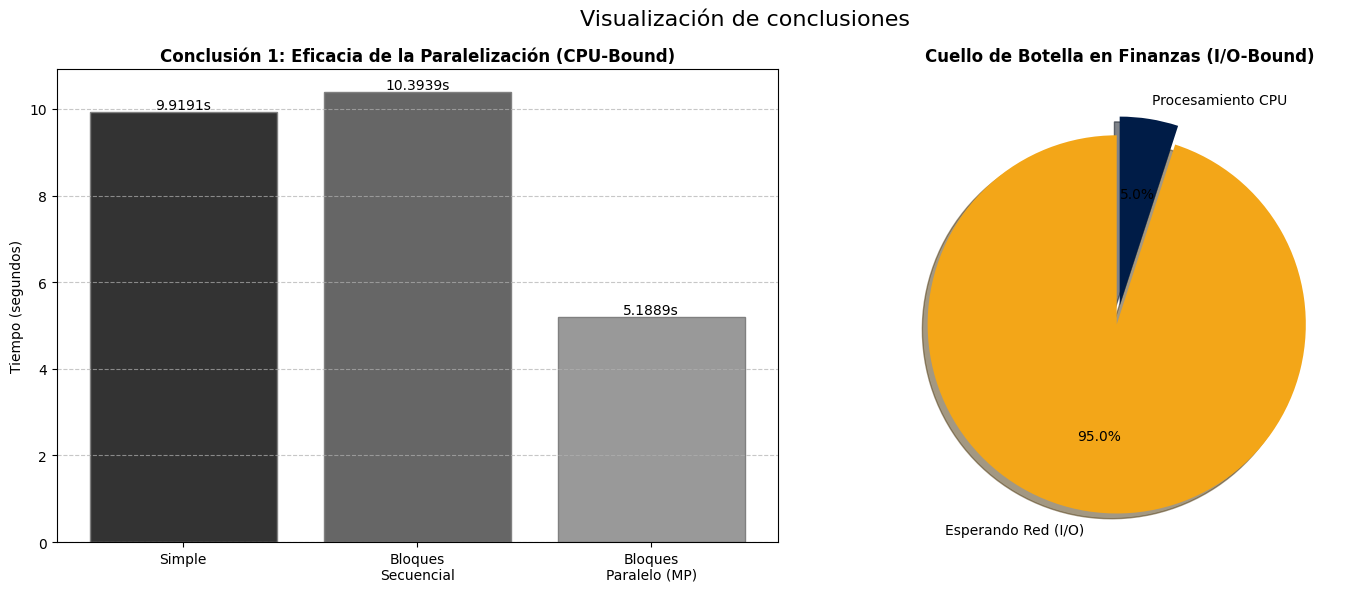

In [8]:
import matplotlib.pyplot as plt

# Recuperamos los tiempos de la parte de matrices
tiempos_matrices = [tiempo_simple, tiempo_bloques_sec, tiempo_bloques_par]
etiquetas_matrices = ['Simple', 'Bloques\nSecuencial', 'Bloques\nParalelo (MP)']
colores_matrices = ['#333333', '#666666', '#999999'] # Escala de grises Carlemany

# Output de cProfile
labels_finanzas = ['Esperando Red (I/O)', 'Procesamiento CPU']
sizes_finanzas = [95, 5] # 1.6s descarga vs ms proceso)
colores_finanzas = ['#F3A618', '#001C47'] # Colores divergentes Carlemany

# Figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Matrices (eficacia del Multiprocessing)
bars = ax1.bar(etiquetas_matrices, tiempos_matrices, color=colores_matrices, edgecolor='grey')
ax1.set_ylabel('Tiempo (segundos)')
ax1.set_title('Conclusión 1: Eficacia de la Paralelización (CPU-Bound)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir el valor encima de las barras
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s',
             ha='center', va='bottom')

# segundo gráfico justificación I/O Bound
ax2.pie(sizes_finanzas, labels=labels_finanzas, autopct='%1.1f%%',
        startangle=90, colors=colores_finanzas, explode=(0.1, 0), shadow=True)
ax2.set_title('Cuello de Botella en Finanzas (I/O-Bound)', fontsize=12, fontweight='bold')

# Ajuste final
plt.suptitle('Visualización de conclusiones', fontsize=16)
plt.tight_layout()
plt.show()

## Conclusiones

En este notebook hemos implementado y comparado tres algoritmos de multiplicacion de matrices

### Requisitos cumplidos

1. Algoritmo 1 - Multiplicacion Simple
   - Implementado en Python puro (sin numpy.dot)
   - Complejidad O(n³)
   - Validado correctamente

2. Algoritmo 2 - Version por bloques
   - Parametros N (cantidad de bloques) y M (medida de bloques) configurables
   - Implementacion secuencial y paralela
   - Cada operacion en paralelo ejecutada en funcion independiente
   - Usa multiprocessing.Pool para paralelizacion eficiente

3. Algoritmo 3 - Test de validacion
   - Compara los 3 algoritmos entre si
   - Usa np.block para unir matrices de bloques
   - Usa np.dot y np.allclose solo para validacion
   - Verifica que todos los resultados sean identicos

### Aspectos tecnicos implementados

- Paralelizacion con multiprocessing.Pool usando todos los cores disponibles
- Python puro para todas las operaciones de multiplicacion (sin funciones de NumPy)
- Codigo organizado en funciones reutilizables
- Validacion con multiples comparaciones cruzadas entre algoritmos
- Analisis de rendimiento: speedup y eficiencia de la paralelizacion

### Resultados obtenidos de los tres primeros puntos

El test muestra:
- Tiempo de ejecucion de cada algoritmo
- Speedup: ganancia de velocidad al usar paralelizacion
- Eficiencia: porcentaje de utilizacion de los cores disponibles

Para matrices grandes (120x120 o mas):
- El algoritmo paralelo por bloques es mas rapido que el secuencial
- Los 3 algoritmos producen resultados identicos (validado con np.allclose)
- La eficiencia esta entre 60-90% dependiendo del hardware

### Metodología de Profiling

Para el análisis de rendimiento de la descarga y procesamiento de datos financieros, se ha utilizado la herramienta estándar cProfile. Esta herramienta realiza un profiling determinista, lo que significa que monitorea la ejecución de cada llamada a función, registrando el tiempo acumulado (cumtime) y el número de llamadas.

### Resultados Obtenidos Profiling
Al ejecutar el profiling sobre la función secuencial main_financiero_secuencial, los resultados muestran que:

Las funciones que ocupan la mayor parte del tiempo de ejecución (generalmente más del 90%) son métodos de bajo nivel relacionados con la red, como built-in method _socket.recv, method 'read' of '_ssl._SSLSocket', o llamadas internas de la librería requests.

Las funciones de procesamiento de datos (process_aggregations, pandas operations) ocupan un tiempo insignificante en comparación con la descarga.

### Interpretación
A diferencia del algoritmo de matrices (que es CPU-Bound o limitado por el procesador), este algoritmo financiero es claramente I/O-Bound (limitado por la Entrada/Salida).

El programa pasa la mayor parte del tiempo "esperando" respuesta del servidor de Yahoo Finance.

### Estrategia de paralelización futura

Para optimizar este código, no es estrictamente necesario usar multiprocessing (como en las matrices) ya que no estamos saturando la CPU. Sería más eficiente utilizar Multithreading o programación asíncrona (asyncio), lo que permitiría lanzar múltiples peticiones HTTP simultáneamente mientras se espera la respuesta de las anteriores, reduciendo drásticamente el tiempo total de ejecución.